In [1]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.0.0'

In [2]:
#建议采用GPU进行训练，需要使用tensorflow-gpu-2.0并设置memory_growth
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu,True)

# 使用预训练的卷积神经网络

想要将深度学习应用于小型图像数据集，一种常用且非常高效的方法是使用预训练网络。预训练网络是一个保存好的网络，之前已在大型数据集上训练好。
使用预训练网络有两种方法：提取特征和微调模型

# 特征提取

特征提取是使用之前网络学到的表示来从新样本中提取有趣的特征。然后将这些特征输入一个新的分类器，从头开始训练。

In [3]:
# 5-16将VGG16卷积基实例化
from tensorflow.keras.applications import VGG16
conv_base=VGG16(weights='imagenet',
               include_top=False,
               input_shape=(150,150,3))

# 
我们向构造函数传递了三个参数：

weights，指定模型初始化的权重检查点
include_top，指定模型最好是否包含全连接层分类器。
input_shape，输入到网络中的图像张量的形状

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# 
最终特征图形状为(4, 4, 512)。我们将在这个特征上添加一个全连接分类器。

有两种方法

1 在你的数据上运行卷积基，将输出保存成硬盘中的Numpy数组，然后用这个数据作为输入，输入到独立的分类器中。这种方法不允许你使用数据增强。
2 在顶部添加Dense层来扩展已有模型，并在输入数据上端到端的运行这个模型。这样可以使用数据增强，但是计算代价比较高。

In [5]:
# 5-17使用预训练的卷积基提取特征
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = r'E:\数据\kaggle_cat_vs_dog\cat_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# 
所提取的特征目前形状(samples, 4, 4, 512)。我们将把它们输入到一个全连接层的分类器中，所以首先我们必须把它们压平(samples, 8192):

In [6]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [7]:
# 5-18定义并训练密集连接分类器
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 787us/sample - loss: 0.6096 - acc: 0.6510 - val_loss: 0.4509 - val_acc: 0.8430
Epoch 2/30
2000/2000 [==============================] - 1s 269us/sample - loss: 0.4339 - acc: 0.8075 - val_loss: 0.3695 - val_acc: 0.8570
Epoch 3/30
2000/2000 [==============================] - 0s 242us/sample - loss: 0.3611 - acc: 0.8560 - val_loss: 0.3321 - val_acc: 0.8670
Epoch 4/30
2000/2000 [==============================] - 0s 240us/sample - loss: 0.3137 - acc: 0.8700 - val_loss: 0.3243 - val_acc: 0.8560
Epoch 5/30
2000/2000 [==============================] - 0s 241us/sample - loss: 0.2907 - acc: 0.8815 - val_loss: 0.2891 - val_acc: 0.8860
Epoch 6/30
2000/2000 [==============================] - 0s 241us/sample - loss: 0.2634 - acc: 0.8940 - val_loss: 0.2784 - val_acc: 0.8930
Epoch 7/30
2000/2000 [==============================] - 1s 271us/sample - loss: 0.2487 - acc: 0.8955 - val_loss: 0.2712 - va

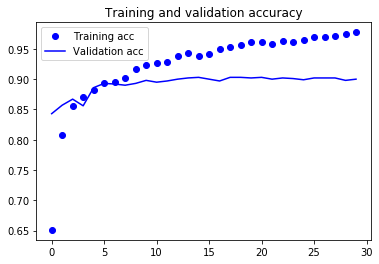

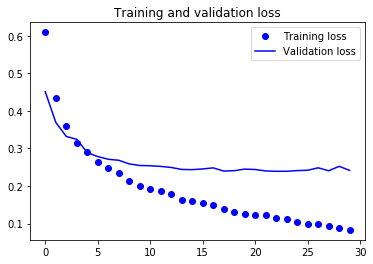

In [9]:
# 5-19绘制结果
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 
验证精度达到了90%


# 使用数据增强的特征提取

In [10]:
# 5-20在卷积基上添加一个密集连接分类器
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


# 
如你所见，VGG16的卷积基有14,714,688个参数，这是非常大的。我们在上添加的分类器有200万个参数。

在编译和训练模型之前，一定要冻结卷积基，冻结一个或多个层是指在训练过程中保持其权重不变。如果不这么做，那么卷积基之前学到的表示将会在训练过程中被修改。
冻结网络的方法是将其trainable属性设为False

In [12]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [13]:
conv_base.trainable = False

In [14]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


# 
设置后，只有添加的两个Dense层的权重才会被训练。

In [15]:
# 5-21利用冻结的卷积基端到端的训练模型
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 29s - loss: 0.5773 - acc: 0.7065 - val_loss: 0.4458 - val_acc: 0.8210
Epoch 2/30
100/100 - 27s - loss: 0.4806 - acc: 0.7815 - val_loss: 0.3813 - val_acc: 0.8420
Epoch 3/30
100/100 - 27s - loss: 0.4434 - acc: 0.8035 - val_loss: 0.3368 - val_acc: 0.8530
Epoch 4/30
100/100 - 27s - loss: 0.4102 - acc: 0.8290 - val_loss: 0.3108 - val_acc: 0.8750
Epoch 5/30
100/100 - 27s - loss: 0.3963 - acc: 0.8255 - val_loss: 0.2959 - val_acc: 0.8760
Epoch 6/30
100/100 - 27s - loss: 0.3588 - acc: 0.8435 - val_loss: 0.2835 - val_acc: 0.8880
Epoch 7/30
100/100 - 27s - loss: 0.3494 - acc: 0.8385 - val_loss: 0.2821 - val_acc: 0.8780
Epoch 8/30
100/100 - 27s - loss: 0.3466 - acc: 0.8495 - val_loss: 0.2634 - val_acc: 0.8950
Epoch 9/30
100/100 - 27s - loss: 0.3390 - acc: 0.8510 - val_loss: 0.2624 - val_acc: 0.8940
Epoch 10/30
100/100 - 27s - loss: 0.3364 - acc: 0.8480 - val_loss: 0.2617 - val_acc: 0.8960
Epoch

In [16]:
# 保存模型
model.save('cats_and_dogs_small_3.h5')

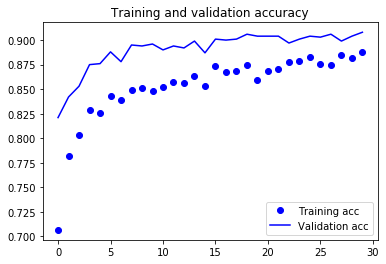

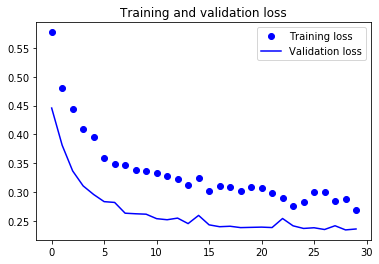

In [17]:
#绘制结果
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 微调模型
另一种模型复用的方法是模型微调，微调是指将顶层的几层解冻，将这解冻的几层和新增加的部分联合训练。

微调网络步骤如下
1)将您的自定义网络添加到已经训练过的基本网络上。

2)冻结基网络。

3)训练你添加的部分。

4)解冻基础网络中的一些层。

5)训练解冻的和添加的部分。

在进行特征提取时，我们已经完成了前三个步骤。让我们继续第四步：我们将解冻我们的conv_base，然后冻结其中部分层


In [18]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [19]:
# 5-22冻结直到某一层的所有层
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [20]:
# 5-23微调模型
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 28s 279ms/step - loss: 0.2933 - acc: 0.8685 - val_loss: 0.3375 - val_acc: 0.8680
Epoch 2/100
100/100 [==============================] - 28s 281ms/step - loss: 0.2428 - acc: 0.8900 - val_loss: 0.3399 - val_acc: 0.8720
Epoch 3/100
100/100 [==============================] - 28s 279ms/step - loss: 0.2324 - acc: 0.8980 - val_loss: 0.2208 - val_acc: 0.9170
Epoch 4/100
100/100 [==============================] - 28s 280ms/step - loss: 0.2088 - acc: 0.9090 - val_loss: 0.2078 - val_acc: 0.9150
Epoch 5/100
100/100 [==============================] - 28s 281ms/step - loss: 0.2030 - acc: 0.9115 - val_loss: 0.2103 - val_acc: 0.9240
Epoch 6/100
100/100 [==============================] - 28s 280ms/step - loss: 0.1982 - acc: 0.9185 - val_loss: 0.2336 - val_acc: 0.9090
Epoch 7/100
100/100 [==============================] - 28s 280ms/step - loss: 0.1723 - acc: 0.9285 - val_loss: 0.1913 - val_acc: 0.9260
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 28s 285ms/step - loss: 0.0314 - acc: 0.9900 - val_loss: 0.2231 - val_acc: 0.9450
Epoch 62/100
100/100 [==============================] - 28s 285ms/step - loss: 0.0326 - acc: 0.9860 - val_loss: 0.2400 - val_acc: 0.9330
Epoch 63/100
100/100 [==============================] - 29s 285ms/step - loss: 0.0268 - acc: 0.9895 - val_loss: 0.2333 - val_acc: 0.9400
Epoch 64/100
100/100 [==============================] - 29s 285ms/step - loss: 0.0222 - acc: 0.9905 - val_loss: 0.4520 - val_acc: 0.9140
Epoch 65/100
100/100 [==============================] - 28s 284ms/step - loss: 0.0425 - acc: 0.9850 - val_loss: 0.2379 - val_acc: 0.9400
Epoch 66/100
100/100 [==============================] - 28s 285ms/step - loss: 0.0285 - acc: 0.9890 - val_loss: 0.4092 - val_acc: 0.9130
Epoch 67/100
100/100 [==============================] - 29s 286ms/step - loss: 0.0342 - acc: 0.9850 - val_loss: 0.2667 - val_acc: 0.9350
Epoch 68/100
100/100 [===================

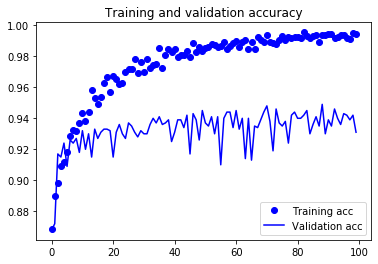

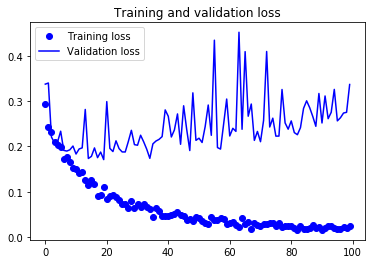

In [21]:
# 绘制结果
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

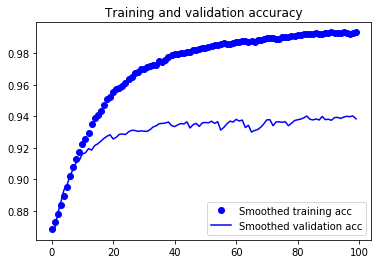

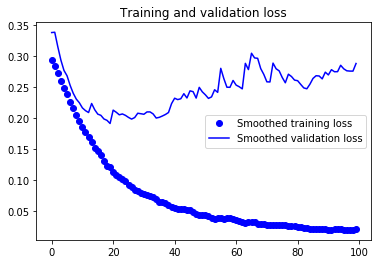

In [22]:
# 5-24使曲线变得平滑
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 在测试数据上最终评估这个模型
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)